In [15]:
#Importation des différentes librairies et modules utilisés

import csv
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
import numpy as np
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import regularizers
import tensorflow as tf
import pandas as pd
import seaborn as sns
from keras.optimizers import Adam,SGD
from sklearn.preprocessing import MinMaxScaler



In [4]:
#Fonction permettant de créer des tableaux à partir des fichiers csv
def create_set(file):
    datas=[]
    with open(file) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=';')#Lecture du fichier csv
        for row in readCSV:
            data=[]
            for nb in row:
                data.append(float(nb))
            datas.append(data)
    datas=np.asarray(datas)
    dataset=datas[290:,1:4]#Suppresion du régime transitoire
    return dataset

In [5]:
#Création du réseau (Model:Autoencoder LSTM)
def autoencoder(X):
    
    inputs = Input(shape=(X.shape[1],X.shape[2]))
    
    encoder = LSTM(27,activation='relu', return_sequences=True,
                   kernel_regularizer=regularizers.l2(0.003))(inputs)
    encoder = LSTM(18,activation='relu', return_sequences=True)(encoder)
    encoder = LSTM(9,activation='relu', return_sequences=True)(encoder)
    encoder = LSTM(6,activation='relu', return_sequences=True)(encoder)
    encoder = LSTM(3,activation='relu', return_sequences=False)(encoder)
    encoder = RepeatVector(X.shape[1])(encoder)
    decoder = LSTM(3,activation='relu', return_sequences=True)(encoder)    
    decoder = LSTM(6,activation='relu', return_sequences=True)(decoder)
    decoder = LSTM(9,activation='relu', return_sequences=True)(decoder)
    decoder = LSTM(18,activation='relu', return_sequences=True)(decoder)
    decoder = LSTM(27,activation='relu',return_sequences=True)(decoder)
    
    decoder = TimeDistributed(Dense(X.shape[2]))(decoder)
    model = Model(inputs=inputs,outputs=decoder)
    
    return model

In [6]:

def compile_auto(model):
    #Compilation du model
    model.compile(optimizer=Adam(lr=0.0003),loss='mse')#Mean Squared error Adam: Optimizer pour train
    model.summary()
    
    es = EarlyStopping(mode='auto',verbose=1,patience=100)
    cp=ModelCheckpoint("model.h5", monitor='val_loss', verbose=0, save_best_only=True)
    
    epochs=50
    bs=16
    #Train du model
    history=model.fit(X_train, X_train, epochs=epochs,batch_size=bs,
                  validation_split=0.05,callbacks=[es,cp])
    #Affichage de la fonction loss 
    fig,ax=plt.subplots(figsize=(14,6), dpi=80)
    ax.plot(history.history['loss'],'b',label='Train')
    ax.plot(history.history['val_loss'],'r',label='Validation')
    ax.set_title('model loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')
    plt.show()
    return history, model

In [7]:
def plot_recons_error(model,X_train):
    #Prediction sur les data avec faute ET afffichage des résultats
    pred_train = model.predict(X_train)
    mse = np.mean(np.power(X_train - pred_train, 2), axis=1)
    error_df = pd.DataFrame({'reconstruction_error_P1': mse[:,0],
                         'reconstruction_error_Q1': mse[:,1],
                         'reconstruction_error_P2': mse[:,2]})
    error_df.describe()
    plt.plot(error_df['reconstruction_error_P1'].index,
             error_df['reconstruction_error_P1'],label='error P1',c='r')
    plt.plot(error_df['reconstruction_error_Q1'].index,
             error_df['reconstruction_error_Q1'],label='error Q1',c='b')
    plt.plot(error_df['reconstruction_error_P2'].index,
             error_df['reconstruction_error_P2'],label='error P2',c='g')
    plt.title('Reconstruction Error')
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.legend(loc='upper right')
    plt.show()
    return pred_train,mse,error_df

In [8]:
#Creation des tableaux
training=create_set('NoFaultDatas.csv')

print('\nShape Training set:')
print('Shape X_train:'+ str(training.shape))


test1=create_set('fautefiltre.csv')

print('\nShape Test1 set:')
print('Shape Test:'+ str(test1.shape))

test2=create_set('fautefuite.csv')

print('\nShape Test2 set:')
print('Shape Test:'+ str(test2.shape))


Shape Training set:
Shape X_train:(1614, 3)

Shape Test1 set:
Shape Test:(711, 3)

Shape Test2 set:
Shape Test:(711, 3)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Sensors Datas leak fault')

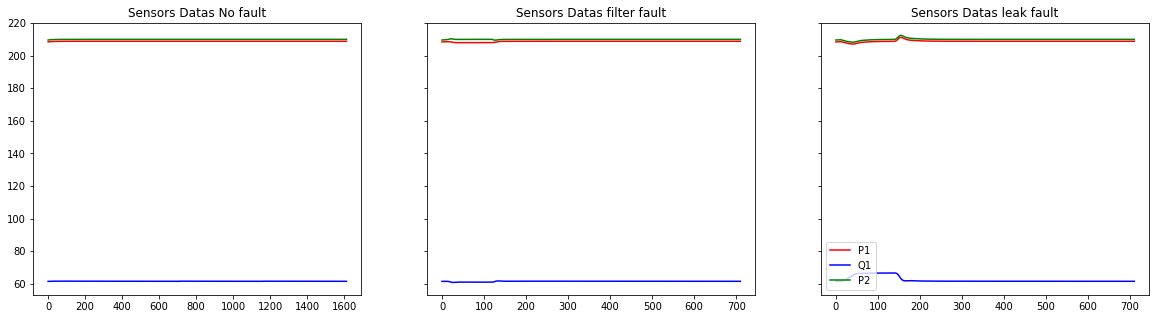

In [9]:
###Plot datas affichage des données originelles###

fig,(ax,ax2,ax3)= plt.subplots(1,3,figsize=(20,5),sharey=True)
ax.plot(training[:,0],label='P1',c='r')
ax.plot(training[:,1],label='Q1',c='b')
ax.plot(training[:,2],label='P2',c='g')
plt.legend(loc='lower left')
ax.set_title('Sensors Datas No fault')  


ax2.plot(test1[:,0],label='P1',c='r')
ax2.plot(test1[:,1],label='Q1',c='b')
ax2.plot(test1[:,2],label='P2',c='g')
plt.legend(loc='lower left')
ax2.set_title('Sensors Datas filter fault')


ax3.plot(test2[:,0],label='P1',c='r')
ax3.plot(test2[:,1],label='Q1',c='b')
ax3.plot(test2[:,2],label='P2',c='g')
plt.legend(loc='lower left')
ax3.set_title('Sensors Datas leak fault')

In [10]:
X_train=training
X_test1=test1
X_test2=test2

### Reshape for LSTM Network###

X_train=X_train.reshape(int(X_train.shape[0]),1,X_train.shape[1])
print('\nShape Xtrain LSTM shape:')
print('Shape Train:'+ str(X_train.shape))


X_test1=X_test1.reshape(int(X_test1.shape[0]),1,X_test1.shape[1])
print('\nShape Xtest LSTM shape:')
print('Shape Test1:'+ str(X_test1.shape))

X_test2=X_test2.reshape(int(X_test2.shape[0]),1,X_test2.shape[1])
print('\nShape Xtest LSTM shape:')
print('Shape Test2:'+ str(X_test2.shape))


Shape Xtrain LSTM shape:
Shape Train:(1614, 1, 3)

Shape Xtest LSTM shape:
Shape Test1:(711, 1, 3)

Shape Xtest LSTM shape:
Shape Test2:(711, 1, 3)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 3)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 27)             3348      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 18)             3312      
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 9)              1008      
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 6)              384       
_________________________________________________________________
lstm_5 (LSTM)                (None, 3)                 120       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 3)              0   

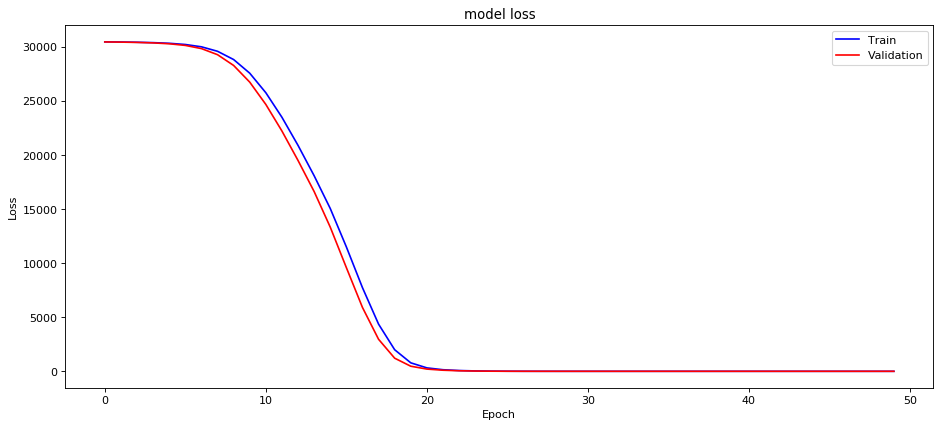

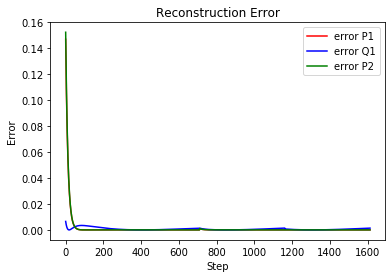

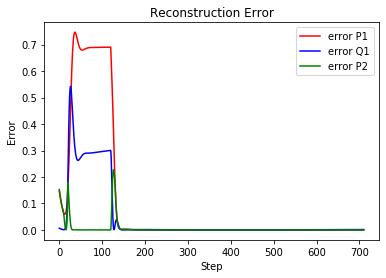

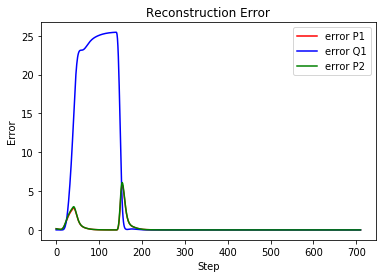

In [11]:
#Appel des fonction pour créer le model et l'entrainé sur les données
### NE PAS FAIRE RUN CETTE CELLULE POUR NE PAS MODIFIER LE MODEL ###
model = autoencoder(X_train)

history, model=compile_auto(model)

pred_train,mse_train,error_train_df=plot_recons_error(model,X_train)

pred_test1,mse_test1,error_test1_df=plot_recons_error(model,X_test1)

pred_test2,mse_test2,error_test2_df=plot_recons_error(model,X_test2)

In [19]:
###TESTER MODEL ICI####
#Fonction permettant de tester le model
def test_model(X_train):
    #Test le model sur d'autre datas
    saved_model = load_model("trained_model.h5")#charge les poids du model pour tester le model
    pred_train = saved_model.predict(X_train)
    mse = np.mean(np.power(X_train - pred_train, 2), axis=1)
    error_df = pd.DataFrame({'reconstruction_error_P1': mse[:,0],
                         'reconstruction_error_Q1': mse[:,1],
                         'reconstruction_error_P2': mse[:,2]})
    #affichage des fautes à travers une reconstruction de l'erreur
    plt.plot(error_df['reconstruction_error_P1'].index,
             error_df['reconstruction_error_P1'],label='error P1',c='r')
    plt.plot(error_df['reconstruction_error_Q1'].index,
             error_df['reconstruction_error_Q1'],label='error Q1',c='b')
    plt.plot(error_df['reconstruction_error_P2'].index,
             error_df['reconstruction_error_P2'],label='error P2',c='g')
    plt.title('Reconstruction Error')
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.legend(loc='upper right')
    plt.show()
    return pred_train,mse,error_df

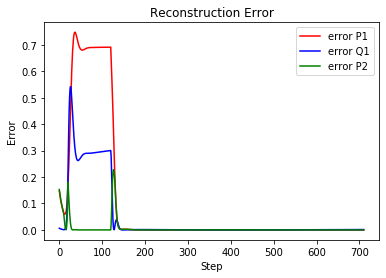

In [ ]:
#remplacer paramètre de la fonction ici pour tester le model sur d'autre datas
test_model(X_test1)
test_model(X_test2)